In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Session 객체를 생성하고 추후에 run 메소드를 수행하여 A와 B를 계산하기 위한 계산 그래프입니다.
sess = tf.Session()

In [3]:
#비선형 데이터를 생성합니다.
#각기 다른 분류에 속하는 두 개의 동심원 데이터를 생성합니다.
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)

#분류는 -1, 1 두 가지만 존재합니다.
y_vals = np.array([1 if y==1 else -1 for y in y_vals])

#그래프에 표시할 수 있도록 각 분류에 속한 데이터의 x, y값을 분리합니다.
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]

class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

In [4]:
#batch의 크기를 정해줍니다.
#여기서 batch란 일괄작업을 하는 단위입니다.
#값이 적으면 적을 수록 정교하고 오래 걸리며, 값이 크면 클 수록 계산은 빨라지지만 값의 정확도는 떨어집니다.
batch_size = 350

#placeholder를 초기화 해줍니다
#외부 입력 값을 받아와서 파라메터화 시켜주기 위한 작업입니다.
#placeholder는 나중에 값을 제공하겠다고 미리 선언해주는 작업입니다.
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

#SVM을 위한 변수를 생성합니다.
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

In [5]:
# Gaussian (RBF) kernel
#가우시안 커널을 생성하고 적용합니다
gamma = tf.constant(-50.0)

#선형 형태의 커널을 사용합니다.
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])

sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))

#선형 커널을 사용시에 아래의 연산으로 바꾸어주면 된다.
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

In [6]:
#이중  최적화 문제를 선언합니다
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))

#tf.negative() 함수로 비용 함수 값의 부호를 바꾸어 최대화 문제를 최소화 무넺로 바꾸어줍니다.
loss = tf.negative(tf.subtract(first_term, second_term))

In [7]:
#예측을 위한 커털을 생성합니다.
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])

#선형 예측을 위한 커널을 생성합니다.
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))

# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

In [8]:
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

In [9]:
#최적화 선언
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

#변수 초기화작업
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
#SVM을 학습 루프
loss_vec = []
batch_accuracy = []

#매 루프마다 비용 벡터와 일괄 작업 대상에 대한 정확도를 기록한다.
#정확도를 측정하기 위해서는 레이스 홀더 3개를 채워야 하지만, 예측 값 정보를 얻기 위해 x 데이터를 두 번 투입한다.
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y, prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 28.005814
Step #500
Loss = -4.7572002
Step #750
Loss = -10.6452265
Step #1000
Loss = -10.48167


In [11]:
#전체 공간에 대한 분류 결과를 시각화 하기 위한 작업입니다.
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1

#모눈 형태의 예측 점들을 만들어 이 모든 점에 대한 예측을 수행합니다.
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals, y_target: np.transpose([y_vals]), prediction_grid: grid_points})

grid_predictions = grid_predictions.reshape(xx.shape)

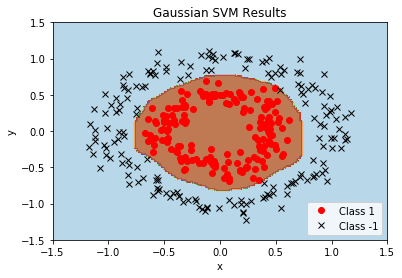

In [12]:
#분류 결과를 그리는 코드입니다.
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)

plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')

plt.title('Gaussian SVM Results')

plt.xlabel('x')
plt.ylabel('y')

plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])

plt.show()

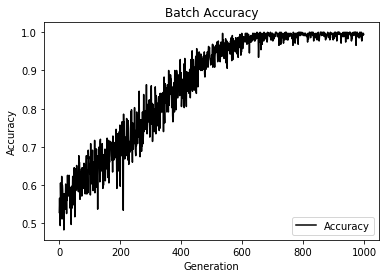

In [13]:
# 일괄 작업의 정확도를 그리는 코드입니다.
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

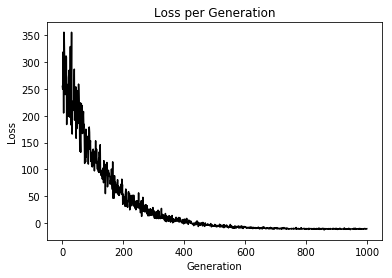

In [14]:
#비용 함수의 값을 그리는 코드입니다.
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()